# Analysis Habit reading  with [Pocket](https://getpocket.com/)

![](unnamed.jpg)

How I'm in the top 1% of readers on @Pocket for 2018! I have decided to analyze my pocket data to try to understand my reading habits.

In this Jupyter Notebook, we are going to cover all ETL process and the data analysis process in a low level of complexity and low data volume, although in some cases, we are going to call analysis methods the middle level like language detect or text analysis.

But before we start writing code, we should ask ourselves, what are we looking for? Or what do we want to find in the analysis? The best way to do this is to ask preliminary questions about the data we want to answer, such as

- How many articles I’ve added to my Pocket till date?
- How many articles have I read / I need to read?
- How large is the gap between added and read articles?
- What topics do I add articles about?

To try answer this question, we will follow the next steps.

0. Import Libraries
1. ***Extract***.Set and get data from the pocket API with [Request]()<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1.Get a consumer_key <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2.Get a request token <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3.Authenticate<br/> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.4.Generate an access_token <br/> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.5.Get Data <br/> 
2. ***Transform and Load*** data with [Pandas]() <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1.Detect the type of python object from the obtained <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.Transform the data to a useful Pandas Dataframe <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3.Pre-analyze the columns of your data frame <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.4.Debug your data frame <br/>
3. ***Data Analysis*** with [Pandas]() <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1.Numerical Analysis <br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2.Text analysis with []() <br/>
4. ***Data Vizualization*** with  [Power BI]() <br/>


finally, before starting with the notebook it's important to note that although the complexity level is low all the principles of data analysis are practice ins this exercise. , this means that with this knowledge you can try to analyze more complex  scenarios 

***0.*** Import necessary libraries

In [30]:
import requests # to make http requests in this case for pocket api

# data transfromation and analysis
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json 
from collections import OrderedDict
import datetime
import pyodbc # Library to manage odbc connection in this case we work with SQl SERVER
import sqlalchemy as sa

# text analysis
from wordcloud import WordCloud, STOPWORDS 
import detectlanguage #Api

#Data visualizacion and plot
import matplotlib.pyplot as plt

%matplotlib inline  

##  1. Extract. Set and get dat from the pocket API

***1.1*** Get a consumer_key by creating a new [Pocket application](https://getpocket.com/developer/apps/new) <br/>
***1.2*** Get a request token<br/>


In [2]:
# pocket_api variable stores the http response
pocket_api = requests.post('https://getpocket.com/v3/oauth/request',
                           data = {'consumer_key':'82710-efa2906be95b400ce9fad6f8',
                                   'redirect_uri':'https://google.com'})

#Test Status If equal to 200 is ok the other way check error reason
print(pocket_api.status_code) 

# print(pocket_api.headers['X-Error'])

# Here is your request_token stored
print(pocket_api.text)


200
code=a9b9694e-c46e-9b7e-4c66-95848b


***1.3*** Authenticate<br/> 
- Modify and paste the link below in the browser and authenticate <br/> 
- Replace text after "?request_token=" with the request_token generated above<br/> 
https://getpocket.com/auth/authorize?request_token=PASTE-YOUR-REQUEST-TOKEN-HERE&amp;amp;amp;amp;amp;amp;amp;amp;amp;redirect_uri=https://getpocket.com/connected_application

 **1.4** Generate an access_token
- After authenticating in the browser, return here
- Use your consumer_key and request_token below

In [3]:
pocket_auth = requests.post('https://getpocket.com/v3/oauth/authorize',
                            data = {'consumer_key':'82710-efa2906be95b400ce9fad6f8',
                                    'code':'51947cf3-8998-32b6-e129-26e865'})
# Check the response: if 200, then it means all OK
pocket_auth.status_code
 
# Check error reason, if any
# print(pocket_auth.headers['X-Error'])
# We're done authenticating,this is your access token
pocket_auth.text


'403 Forbidden'

***1.5.*** Get Data from the api

In [4]:
# Get data from the API
# Reference: https://getpocket.com/developer/docs/v3/retrieve
pocket_add = requests.post('https://getpocket.com/v3/get',
                           data= {'consumer_key':'82710-efa2906be95b400ce9fad6f8',
                                  'access_token':'81159e5f-c60a-dadd-0b50-1b1c40',#private
                                  'state':'all',
                                  'detailType':'simple'})
 
# Check the response: if 200, then it means all OK
# pocket_add.status_code
 
#pocket_add.text

## 2.Transform data

***2.1.*** Detect the type of python object from the obtained

In [5]:
print(type(pocket_add))

<class 'requests.models.Response'>



***2.2.*** Transform from respuest reponse object to pd.df

In [6]:
texto=pocket_add.text
json_data = json.loads(texto)
df= pd.DataFrame.from_dict(json_data['list']).T
df.head()

,amp_url,domain_metadata,excerpt,favorite,given_title,given_url,has_image,has_video,is_article,is_index,...,resolved_url,sort_id,status,time_added,time_favorited,time_read,time_to_read,time_updated,top_image_url,word_count
2442351725,NaN,NaN,There are times when working with different pa...,0,Python Data: Quick Tip: Comparing two pandas d...,https://pythondata.com/quick-tip-comparing-two...,0,0,1,0,...,https://pythondata.com/quick-tip-comparing-two...,0,0,1546608445,0,0,NaN,1546608447,https://ir-na.amazon-adsystem.com/e/ir?t=edbho...,232
2442848392,NaN,"{'name': 'Towards Data Science', 'logo': 'http...",Logistic Regression is one of the basic and po...,0,302 Found,https://towardsdatascience.com/understanding-l...,1,0,1,0,...,https://towardsdatascience.com/understanding-l...,1,0,1546606419,0,0,3,1546606420,https://cdn-images-1.medium.com/max/1200/1*715...,640
2068946,NaN,"{'name': 'Wikipedia', 'logo': 'https://logo.cl...","In statistics, logistic regression, or logit r...",0,Logistic regression - Wikipedia,https://en.wikipedia.org/wiki/Logistic_regression,1,0,1,0,...,https://en.wikipedia.org/wiki/Logistic_regression,2,0,1546606066,0,0,55,1546606066,https://upload.wikimedia.org/wikipedia/commons...,12010
2382135264,NaN,"{'name': 'Hacker Noon', 'logo': 'https://logo....","So, you’re playing with ML models and you enco...",0,302 Found,https://hackernoon.com/what-is-one-hot-encodin...,1,1,1,0,...,https://hackernoon.com/what-is-one-hot-encodin...,3,0,1546604896,0,0,NaN,1546604896,https://cdn-images-1.medium.com/max/1200/1*VEU...,386
1702096649,NaN,NaN,,0,glorot10a.pdf,http://proceedings.mlr.press/v9/glorot10a/glor...,0,0,0,0,...,http://proceedings.mlr.press/v9/glorot10a/glor...,4,0,1546553387,0,0,NaN,1546553387,NaN,0


***2.3.*** Pre-analyze the columns of your data frame

In [7]:
df.notnull().apply(pd.Series.value_counts)


,amp_url,domain_metadata,excerpt,favorite,given_title,given_url,has_image,has_video,is_article,is_index,...,resolved_url,sort_id,status,time_added,time_favorited,time_read,time_to_read,time_updated,top_image_url,word_count
False,2243,1813,4,NaN,NaN,NaN,4,4,4,4,...,4,NaN,NaN,NaN,NaN,NaN,1250,NaN,1192,4
True,328,758,2567,2571.0,2571.0,2571.0,2567,2567,2567,2567,...,2567,2571.0,2571.0,2571.0,2571.0,2571.0,1321,2571.0,1379,2567


In [8]:
df.dtypes

amp_url                     object
domain_metadata             object
excerpt                     object
favorite                    object
given_title                 object
given_url                   object
has_image                   object
has_video                   object
is_article                  object
is_index                    object
item_id                     object
lang                        object
listen_duration_estimate    object
resolved_id                 object
resolved_title              object
resolved_url                object
sort_id                     object
status                      object
time_added                  object
time_favorited              object
time_read                   object
time_to_read                object
time_updated                object
top_image_url               object
word_count                  object
dtype: object

***2.4.*** Debug your data frame

In [9]:
# Clean up the dataset
available = df.notnull()
mask= available['word_count']&available['time_to_read']
df = df[mask]

In [10]:

df.dtypes
df[['status','favorite','word_count','time_to_read']] = df[['status','favorite','word_count','time_to_read']].astype(int)
df['time_added'] = pd.to_datetime(df['time_added'],unit='s')
df['time_read'] = pd.to_datetime(df['time_read'],unit='s')

df['date_added'] = df['time_added'].dt.date
df['date_read'] = df['time_read'].dt.date

# Check the data types
df.dtypes


amp_url                             object
domain_metadata                     object
excerpt                             object
favorite                             int32
given_title                         object
given_url                           object
has_image                           object
has_video                           object
is_article                          object
is_index                            object
item_id                             object
lang                                object
listen_duration_estimate            object
resolved_id                         object
resolved_title                      object
resolved_url                        object
sort_id                             object
status                               int32
time_added                  datetime64[ns]
time_favorited                      object
time_read                   datetime64[ns]
time_to_read                         int32
time_updated                        object
top_image_u

# 3. Data Analysis
### 3.1. Answer questions using data

In [11]:
df.head()

,amp_url,domain_metadata,excerpt,favorite,given_title,given_url,has_image,has_video,is_article,is_index,...,status,time_added,time_favorited,time_read,time_to_read,time_updated,top_image_url,word_count,date_added,date_read
2442848392,NaN,"{'name': 'Towards Data Science', 'logo': 'http...",Logistic Regression is one of the basic and po...,0,302 Found,https://towardsdatascience.com/understanding-l...,1,0,1,0,...,0,2019-01-04 12:53:39,0,1970-01-01,3,1546606420,https://cdn-images-1.medium.com/max/1200/1*715...,640,2019-01-04,1970-01-01
2068946,NaN,"{'name': 'Wikipedia', 'logo': 'https://logo.cl...","In statistics, logistic regression, or logit r...",0,Logistic regression - Wikipedia,https://en.wikipedia.org/wiki/Logistic_regression,1,0,1,0,...,0,2019-01-04 12:47:46,0,1970-01-01,55,1546606066,https://upload.wikimedia.org/wikipedia/commons...,12010,2019-01-04,1970-01-01
909334469,NaN,NaN,The result of a JOIN does not depends on the p...,0,From SQL to DAX: Joining Tables - SQLBI,https://www.sqlbi.com/articles/from-sql-to-dax...,1,0,1,0,...,0,2019-01-03 14:37:28,0,1970-01-01,8,1546526248,https://www.sqlbi.com/wp-content/uploads/Natur...,1660,2019-01-03,1970-01-01
2435595681,NaN,"{'name': 'Towards Data Science', 'logo': 'http...",Recommender systems are one of the most common...,0,302 Found,https://towardsdatascience.com/building-and-te...,1,1,1,0,...,0,2019-01-02 13:08:20,0,1970-01-01,5,1546434500,https://cdn-images-1.medium.com/max/1200/1*dOM...,1055,2019-01-02,1970-01-01
2435726794,NaN,NaN,"As a marketing manager, you want a set of cust...",0,Decision Tree Classification in Python,https://www.datacamp.com/community/tutorials/d...,1,0,1,0,...,0,2019-01-02 12:51:08,0,1970-01-01,9,1546433469,https://s3.amazonaws.com/datacamp-community-pr...,2076,2019-01-02,1970-01-01


In [12]:
 
# How many items are there in my Pocket?
print('How many items are there in my Pocket? R\{}'.format(df['item_id'].count()))
 
# What % of articles are read?
print('What % of articles are read? R\{}'.format((df['status'].sum()*100)/df['item_id'].count()))


How many items are there in my Pocket? R\1321
What % of articles are read? R\98.03179409538228


In [13]:
# How long is the average article in my Pocket? (minutes)
df['time_to_read'].describe()

count    1321.000000
mean        8.099924
std         9.107889
min         3.000000
25%         4.000000
50%         6.000000
75%         9.000000
max       155.000000
Name: time_to_read, dtype: float64

In [14]:
# How long is the average article in my Pocket? (word count)
df['word_count'].describe()

count     1321.000000
mean      1775.887207
std       2004.766245
min        550.000000
25%        842.000000
50%       1250.000000
75%       2057.000000
max      34197.000000
Name: word_count, dtype: float64

In [15]:
# How many words have I read till date?
print('How many words have I read till date? R/{}'.format(df.loc[df['status'] == 1, 'word_count'].sum()))
 
# How many books is this equivalent to?
print('How many books is this equivalent to? R/{}'.format(df.loc[df['status'] == 1, 'word_count'].sum()/64000))


How many words have I read till date? R/2286730
How many books is this equivalent to? R/35.73015625


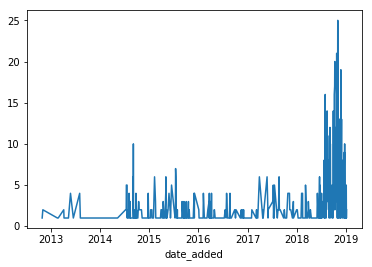

In [16]:
# How were the articles added over time?
plot_added = df.groupby('date_added')['item_id'].count()
plot_added.plot()


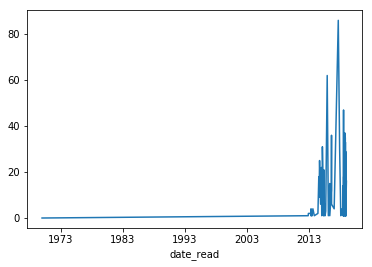

In [17]:
# How were the articles read over time?
plot_read = df.groupby('date_read')['status'].sum()
plot_read.plot()

As the achievement of belonging to 1% of readers in pocket is based on data 2018 it is necessary to filter the data to analyze only this information.

In [18]:
# filter Time
start_date ='01-01-2018'
end_date = '31-12-2018'
mask_2 = (df['time_read'] > start_date) & (df['time_read'] <= end_date)
df_2018= df[mask_2]
# How many words have I read till date?
print('How many words have I read in 2018? R/{}'.format(df_2018.loc[df['status'] == 1, 'word_count'].sum()))                                                                     
# How many books is this equivalent to?
print('How many books is this equivalent to? R/{}'.format(df_2018.loc[df['status'] == 1, 'word_count'].sum()/64000))


How many words have I read in 2018? R/1465004
How many books is this equivalent to? R/22.8906875


# Text Analysis

Part of the analysis I'm going to do is supported by an API that detects the language, because developing and training the algorithm necessary to detect the language is out of reach and would greatly extend the article

We have to do some transformation more to can use teh API

In [19]:
#prepare data to text analysis again tranformation reindexing
df_2018 = df_2018.reset_index()
texto = df_2018['excerpt'].tolist()


In [20]:
detectlanguage.configuration.api_key = "3a6545f3c5a180ff549ddf334d2ec8ec"
detectlanguage.user_status()    

{'date': '2019-01-07',
 'requests': 0,
 'bytes': 0,
 'plan': 'FREE',
 'plan_expires': None,
 'daily_requests_limit': 1000,
 'daily_bytes_limit': 1048576,
 'status': 'ACTIVE'}

In [21]:
language_analysis = detectlanguage.detect(texto)
type(language_analysis)

list

In [22]:
language_analysis

[[{'language': 'en', 'isReliable': True, 'confidence': 10.7}],
 [{'language': 'en', 'isReliable': True, 'confidence': 12.26}],
 [{'language': 'en', 'isReliable': True, 'confidence': 12.44}],
 [{'language': 'en', 'isReliable': True, 'confidence': 12.58}],
 [{'language': 'en', 'isReliable': True, 'confidence': 10.71}],
 [{'language': 'en', 'isReliable': True, 'confidence': 10.65}],
 [{'language': 'en', 'isReliable': True, 'confidence': 12.92}],
 [{'language': 'en', 'isReliable': True, 'confidence': 13.17}],
 [{'language': 'en', 'isReliable': True, 'confidence': 12.42}],
 [{'language': 'es', 'isReliable': True, 'confidence': 5.62}],
 [{'language': 'en', 'isReliable': True, 'confidence': 11.4}],
 [{'language': 'en', 'isReliable': True, 'confidence': 12.99}],
 [{'language': 'en', 'isReliable': True, 'confidence': 12.13}],
 [{'language': 'en', 'isReliable': True, 'confidence': 14.11}],
 [{'language': 'en', 'isReliable': True, 'confidence': 12.3}],
 [{'language': 'en', 'isReliable': True, 'co

In [27]:
# get the language field from the list return and add to the dataframe 

lista = []

for listItem in language_analysis:
    for item in listItem :
        lista.append(item.get('language'))
           
            
language_column= pd.Series(lista)           

df_2018['Language']= language_column

df_2018.to_csv("pocket_2018.csv")



In [25]:
df_2018.head()

,index,amp_url,domain_metadata,excerpt,favorite,given_title,given_url,has_image,has_video,is_article,...,time_added,time_favorited,time_read,time_to_read,time_updated,top_image_url,word_count,date_added,date_read,Language
0,1974827225,NaN,"{'name': 'Towards Data Science', 'logo': 'http...","A few weeks ago, a colleague sent me a spreads...",1,Seven Clean Steps To Reshape Your Data With Pa...,https://towardsdatascience.com/seven-clean-ste...,1,0,1,...,2018-12-20 15:06:41,1546195622,2018-12-30 18:47:05,10,1546195706,https://cdn-images-1.medium.com/max/1200/1*jxg...,2114,2018-12-20,2018-12-30,en
1,2137887466,NaN,NaN,I joined Facebook in May 2007. Over the past 1...,1,Analyzing 10 Years of My Facebook Data - Lee ...,https://www.leejamesrobinson.com/blog/analyzin...,1,0,1,...,2018-12-20 13:22:49,1546195359,2018-12-30 18:42:40,4,1546433123,http://www.leejamesrobinson.com/img/facebook/b...,934,2018-12-20,2018-12-30,en
2,247320106,NaN,"{'name': 'Pocket', 'logo': 'https://logo.clear...",The Pocket Authentication API uses a variant o...,0,Pocket Developer Program: Pocket Authenticatio...,https://getpocket.com/developer/docs/authentic...,0,0,1,...,2018-12-19 19:33:46,0,2018-12-21 13:30:47,9,1545399047,NaN,2029,2018-12-19,2018-12-21,en
3,1408395881,https://www.technologyreview.com/s/602344/the-...,"{'name': 'MIT Technology Review', 'logo': 'htt...","In the last couple of years, deep learning tec...",0,The Extraordinary Link Between Deep Neural Net...,https://www.technologyreview.com/s/602344/the-...,1,0,1,...,2018-12-19 12:33:20,0,2018-12-30 19:06:26,5,1546196792,https://cdn.technologyreview.com/i/images/deep...,1074,2018-12-19,2018-12-30,en
4,2426258218,NaN,NaN,Instagram machine learning has grown a lot sin...,0,302 Found,https://instagram-engineering.com/lessons-lear...,1,0,1,...,2018-12-19 11:46:21,0,2018-12-30 18:40:23,7,1546195394,https://cdn-images-1.medium.com/max/1200/1*gkK...,1617,2018-12-19,2018-12-30,en


In [75]:
df_2018_En= df_2018[df_2018.Language == 'en']
df_2018_Es= df_2018[df_2018.Language == 'es']

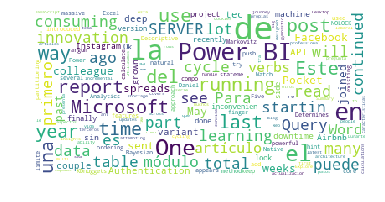

In [76]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=300,
                      max_font_size=40, 
                      random_state=42
                      ).generate(str(df_2018_En['excerpt']))
 
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("Pocket Wordcloud.png", dpi=900)

In [78]:
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

In [ ]:
from IPython.display import IFrame

powerBiEmbed = 'https://app.powerbi.com/view?r=[...]'

IFrame(powerBiEmbed, width=800, height=600)

In [68]:
?WordCloud

### Load Data ( Optional Step just to production)

In [40]:
import urllib
params = urllib.parse.quote_plus(r"Driver={SQL Server};Server=localhost;Database=Projects;Trusted_Connection=Yes")
engine = sa.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params))
df_2018.to_sql('Pocket_Data', con=engine, index=False,  if_exists='append')

Database created


In [1]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


ModuleNotFoundError: No module named 'wordcloud'